In [2]:
import csv
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import chess
import chess.pgn
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.utils import shuffle

In [3]:
#Following Board Representation from Paper
def bit_board_encoder(board):
    bit_boards = {"P": np.zeros(64),"N": np.zeros(64),"B": np.zeros(64),
                  "R": np.zeros(64),"Q": np.zeros(64),"K": np.zeros(64),
                  "p": np.zeros(64),"n": np.zeros(64),"b": np.zeros(64),
                  "r": np.zeros(64),"q": np.zeros(64),"k": np.zeros(64)}
    for i in range(0, 64):
        square = board.piece_at(i)
        if square is not None:
            if square.symbol().isupper():
                bit_boards[square.symbol()][i] = 1
            else:
                bit_boards[square.symbol()][i] = 1
            
    bit_board = np.concatenate([bit_boards["P"], bit_boards["R"], bit_boards["N"], bit_boards["B"], 
                                bit_boards["Q"], bit_boards["K"], bit_boards["p"], bit_boards["r"],
                                bit_boards["n"], bit_boards["b"], bit_boards["q"], bit_boards["k"]])
    return bit_board

#All Pieces on one board
def board_encoder(board):
    board_rep = np.zeros(64);
    for i in range(0, 64):
        square = board.piece_at(i)
        if square is not None:
            board_rep[i] = {"P": 1,"N": 3,"B": 3.3,
                            "R": 5,"Q": 9.5,"K": 10,
                            "p": 1,"n": 3,"b": 3.3,
                            "r": 5,"q": 9.5,"k": 10}[square.symbol()]
            
    return board_rep


In [4]:
stockfish = pandas.read_csv('C:\\Users\\Christopher.Atkeson\\Documents\\web_project\\chess_evaluation\\stockfish.csv')
pgn = open('C:\\Users\\Christopher.Atkeson\\Documents\\web_project\\chess_evaluation\\data.pgn')
#stockfish = pandas.read_csv('/Users/chrisatkeson/Documents/web_project/chess_evaluation/stockfish.csv')
#pgn = open('/Users/chrisatkeson/Documents/web_project/chess_evaluation/data.pgn')

In [5]:
evaluations = stockfish['MoveScores'];
all_evaluations = [];
all_positions =[];
all_moves = [];

count = 0

for game in evaluations:
    count = count+1
    if count % 500 == 0:
        print(count)
    position = chess.pgn.read_game(pgn)
    for evaluation in game.split():
        all_positions.append(position.board())
        next_position = position.variations[0]
        position = next_position
        if evaluation.isdigit():
            all_evaluations.append([float(evaluation)])
        elif evaluation.lstrip('-').isdigit():
            all_evaluations.append([float(evaluation.lstrip('-'))*-1.0])
        else: 
            all_evaluations.append([0])

    if count == 5000:
        break
        

500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [6]:
#normalize evaluations      
standard_dev = np.std(all_evaluations)
mean_evaluation = np.mean(all_evaluations)
#Unit Variance and 0 mean
all_evaluations = (np.asarray(all_evaluations) - mean_evaluation)/standard_dev

max_evaluation = np.max(all_evaluations)
min_evaluation = np.min(all_evaluations)
max_abs_evaluation = max(max_evaluation, min_evaluation*-1.0)

#normalized_evaluations = all_evaluations * 1/max_abs_evaluation
normalized_evaluations = np.tanh(all_evaluations)

#Constuct Board Vectors
positions = []
for position in all_positions:
    positions.append(bit_board_encoder(position))
    
positions, normalized_evaluations = shuffle(positions, normalized_evaluations, random_state=0)

num_rows = len(positions)
num_cols_x = 768
num_cols_y = 1

X = np.zeros((num_rows,num_cols_x))
Y = np.zeros((num_rows,num_cols_y))

for k in range(0,num_rows):
    X[k,:] = positions[k][:]
    Y[k,:] = normalized_evaluations[k][:]

X_train = X[0:300000]
X_test = X[300001:400000]

Y_train = Y[0:300000]
Y_test = Y[300001:400000]

In [21]:
#Keras Model

n_input = 768 # 12 8x8 chessboards

model = Sequential()
model.add(Dense(500, activation = 'relu', input_shape=(n_input,)))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1,activation='tanh'))

model.compile(optimizer='rmsprop',
              loss='mse')

model.fit(X_train, Y_train, epochs=10, batch_size=100)

Epoch 1/10
300000/300000 [==============================] - 21s 70us/step - loss: 0.0384
Epoch 2/10
300000/300000 [==============================] - 22s 72us/step - loss: 0.0171
Epoch 3/10
300000/300000 [==============================] - 21s 69us/step - loss: 0.0119
Epoch 4/10
300000/300000 [==============================] - 20s 68us/step - loss: 0.0093
Epoch 5/10
300000/300000 [==============================] - 21s 70us/step - loss: 0.0078
Epoch 6/10
300000/300000 [==============================] - 20s 68us/step - loss: 0.0067
Epoch 7/10
300000/300000 [==============================] - 22s 73us/step - loss: 0.0059
Epoch 8/10
300000/300000 [==============================] - 22s 73us/step - loss: 0.0053
Epoch 9/10
300000/300000 [==============================] - 21s 70us/step - loss: 0.0048
Epoch 10/10
300000/300000 [==============================] - 21s 69us/step - loss: 0.0044


In [22]:
#Random: 0.005
score = model.evaluate(X_test, Y_test, batch_size=50)
print(score)
predictions = model.predict(X_test)

99999/99999 [==============================] - 3s 30us/step
0.010544026733881306


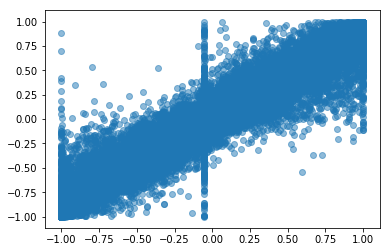

In [23]:
# GET RID OF THE N/A VALUES THAT YOU LEFT AS ZERO
plt.scatter(Y_test[0:99999], predictions[0:99999], alpha=0.5)
plt.show()

In [158]:
# Neural Net
learning_rate = 0.01

# Network Parameters
n_hidden_1 = 100 # 1st layer number of neurons
n_hidden_2 = 100 # 2nd layer number of neurons
n_input = 768 # 12 8x8 chessboards
n_classes = 1

# tf Graph input
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, 1])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Create model
def multilayer_perceptron(x):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    out_layer = tf.nn.tanh(out_layer)
    return out_layer

In [118]:
# Construct model
output = multilayer_perceptron(X)
# using mean squared error cost function
cost  = tf.square(output - Y)
# using Gradient Descent algorithm
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    cost_history=[]
    
    for step in np.arange(1):
        for x in range(0,100):
            start = x*100
            end = start+999
            sess.run(optimizer, feed_dict={X:positions[start:end], Y:normalized_evaluations[start:end]})
            cost_history = np.append(cost_history, sess.run(cost,feed_dict={X:positions[start:end], Y:normalized_evaluations[start:end]}))
    
        print(cost_history)



[0.99159807 1.01985145 1.01022673 ... 0.92674917 0.95122498 1.        ]


In [37]:
print(normalized_evaluations)

[0.00145725 0.0013763  0.0009715  ... 0.83273964 0.83273964 0.83330635]
